In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor


def check_collinearity(data, exclude):
    X = data.drop(["won", "move-index"] + exclude, axis=1)
    # check collinearity using variance inflation factor
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    print(vif_data)


class EvaluationModel():
    def __init__(self, split_indices, blend_range=2):
        self.split_indices = split_indices
        self.blend_range = blend_range
        self.fitted = False

        split_indices.sort()
        assert split_indices[0] == 0

        n_clfs = len(split_indices)
        self.clfs = [LogisticRegression() for _ in range(n_clfs)]
        self.train_scores = []
        self.data_fractions = []

        # find weights for properly blending together classifiers
        weights = []
        for i in range(n_clfs):
            # set the area belonging to this classifier as weight 1
            unblended = np.zeros((split_indices[-1] + 2*blend_range + 1))
            start = max(0, split_indices[i])
            if i < len(split_indices)-1:
                stop = split_indices[i+1]
            else:
                stop = len(unblended) + 1
            unblended[start:stop] = 1

            # blend it with the zeros around the edges, appending copies of the start to the start to make up for valid convolution
            if blend_range != 0:
                blend_kernel = np.ones(blend_range*2) / (blend_range*2)
                unblended = np.concatenate(
                    ([unblended[0]]*blend_range, unblended))
                weights.append(np.convolve(
                    unblended, blend_kernel, mode="valid"))
            else:
                weights.append(unblended)

        self.clf_weights = np.array(weights).T

    def get_data_weights(self, X, clf_index=None):
        # X is a pandas dataframe, should include "move-index" column

        # floor the move indices so that if larger than the size of self.clf_weights, we just take the last weight
        move_indices = np.minimum(
            self.clf_weights.shape[0]-1, X["move-index"].values)
        return self.clf_weights[move_indices, clf_index]

    def fit(self, X, y):
        # X is a pandas dataframe, should include "move-index" column
        # fit each of the classifiers on their region of data (by weighting the data)

        self.X_train = X
        self.y_train = y

        X_no_move_index = X.drop("move-index", axis=1)
        self.coef_names = X_no_move_index.columns

        for i, clf in enumerate(self.clfs):
            weights = self.get_data_weights(X, i)
            self.data_fractions.append(np.mean(weights))
            clf.fit(X_no_move_index, y, sample_weight=weights)

        self.fitted = True
        for i, clf in enumerate(self.clfs):
            self.train_scores.append(self.score(X, y, i))

    def predict(self, X):
        X_no_move_index = X.drop("move-index", axis=1)
        decision_scores = []
        for i, clf in enumerate(self.clfs):
            weights = self.get_data_weights(X, i)
            logits = X_no_move_index @ clf.coef_.T + clf.intercept_
            decision_scores.append(np.multiply(weights, np.squeeze(logits)))

        mean_decision_scores = np.mean(np.array(decision_scores), axis=0)
        return (mean_decision_scores > 0).astype(int)

    def score(self, X, y, clf_index=None):
        if not self.fitted:
            raise Exception("Not fitted yet")

        if clf_index is None:
            return accuracy_score(self.predict(X), y)

        relevant_points_mask = self.get_data_weights(X, clf_index) > 0
        # if no relevant points, then not doing anything, just return 0
        if relevant_points_mask.sum() == 0:
            return 0
        pred = self.predict(X)[relevant_points_mask]
        gt = y[relevant_points_mask]
        return accuracy_score(pred, gt)

    def plot_coefs(self, X_test=None, y_test=None, loco=False):
        if not self.fitted:
            raise Exception("Not fitted yet")

        fig, axes = plt.subplots(
            nrows=2, ncols=len(self.clfs), figsize=(14, 12))

        loco_importances = None
        if loco and X_test is not None and y_test is not None:
            print(f"Calculating variable importances")
            loco_importances = self.get_loco_importance(
                X_test, y_test, relevant_only=True)

        for i, clf in enumerate(self.clfs):
            axis = axes[0] if len(self.clfs) == 1 else axes[0][i]
            axis.barh(self.coef_names, clf.coef_[0])
            axis.barh(["bias"], clf.intercept_[0])

            # title
            if i < len(self.split_indices)-1:
                clf_name = f"{self.split_indices[i]} ≤ move index ≤ {self.split_indices[i+1]}"
            else:
                clf_name = f"{self.split_indices[i]} ≤ move index"
            title = f"{clf_name} ({100*self.data_fractions[i]:.0f}% data)\n" \
                    f"Train accuracy: {self.train_scores[i]:.4f}"
            if X_test is not None and y_test is not None:
                title += f"\nTest accuracy: {self.score(X_test, y_test, i):.4f}"
            axis.set_title(title)

            if loco_importances is not None:
                loco_axis = axes[1] if len(self.clfs) == 1 else axes[1][i]
                loco_axis.barh(self.coef_names, loco_importances[:, i])
                loco_axis.set_title(
                    "Test accuracy reduction when predictor is left out,\nfor positions where predictor is nonzero")

        suptitle = f"Train accuracy: {self.score(self.X_train, self.y_train):.4f}"
        if X_test is not None and y_test is not None:
            suptitle += f"\nTest accuracy: {self.score(X_test, y_test):.4f}"
        fig.suptitle(suptitle)
        plt.tight_layout()
        plt.show()

    def get_loco_importance(self, X_test, y_test, relevant_only=True):
        # relevant_only means only look at data points where the predictor value was nonzero
        importances = []
        # try leaving each covariate out and seeing how the score decreases
        for covar in self.coef_names:
            if covar == "move-index":
                continue
            X_loco_train = self.X_train.drop(covar, axis=1)
            X_loco_test = X_test.drop(covar, axis=1)
            clf = EvaluationModel(self.split_indices, self.blend_range)
            clf.fit(X_loco_train, self.y_train)

            clf_importances = []
            if relevant_only:
                irrelevant = np.where(np.squeeze(X_test[covar].values) == 0)[0]
                for i in range(len(self.clfs)):
                    orig_score = self.score(X_test.drop(irrelevant), y_test.drop(irrelevant), i)
                    loco_score = clf.score(X_loco_test.drop(irrelevant), y_test.drop(irrelevant), i)
                    clf_importances.append(orig_score - loco_score)
            else:
                for i in range(len(self.clfs)):
                    orig_score = self.score(X_test, y_test, i)
                    loco_score = clf.score(X_loco_test, y_test, i)
                    clf_importances.append(orig_score - loco_score)

            importances.append(clf_importances)

        return np.array(importances)

    def print_javascript_params(self):
        if not self.fitted:
            raise Exception("Not fitted yet")
        pass


def split_data(X, y, train_fraction):
    assert len(X) == len(y)
    assert train_fraction > 0 and train_fraction <= 1
    split_idx = int(len(X) * train_fraction)
    # split (note that pandas slice indices are both inclusive)
    return (
        X.loc[:split_idx-1].reset_index(drop=True),
        X.loc[split_idx:].reset_index(drop=True),
        y.loc[:split_idx-1].reset_index(drop=True),
        y.loc[split_idx:].reset_index(drop=True)
    )


def evaluate_features(csv_path, loco=True, check_vif=False):
    data = pd.read_csv(csv_path)
    X = data.drop(["won"], axis=1)
    y = data["won"]
    X_train, X_test, y_train, y_test = split_data(X, y, 0.8)
    if check_vif:
        check_collinearity(data, exclude=[])
    model = EvaluationModel([0, 19], blend_range=2)
    model.fit(X_train, y_train)
    print("training", model.score(X_train, y_train))
    print("testing", model.score(X_test, y_test))
    model.plot_coefs(X_test, y_test, loco=loco)

training 0.7457633115160092
testing 0.7181265034668176
Calculating variable importances


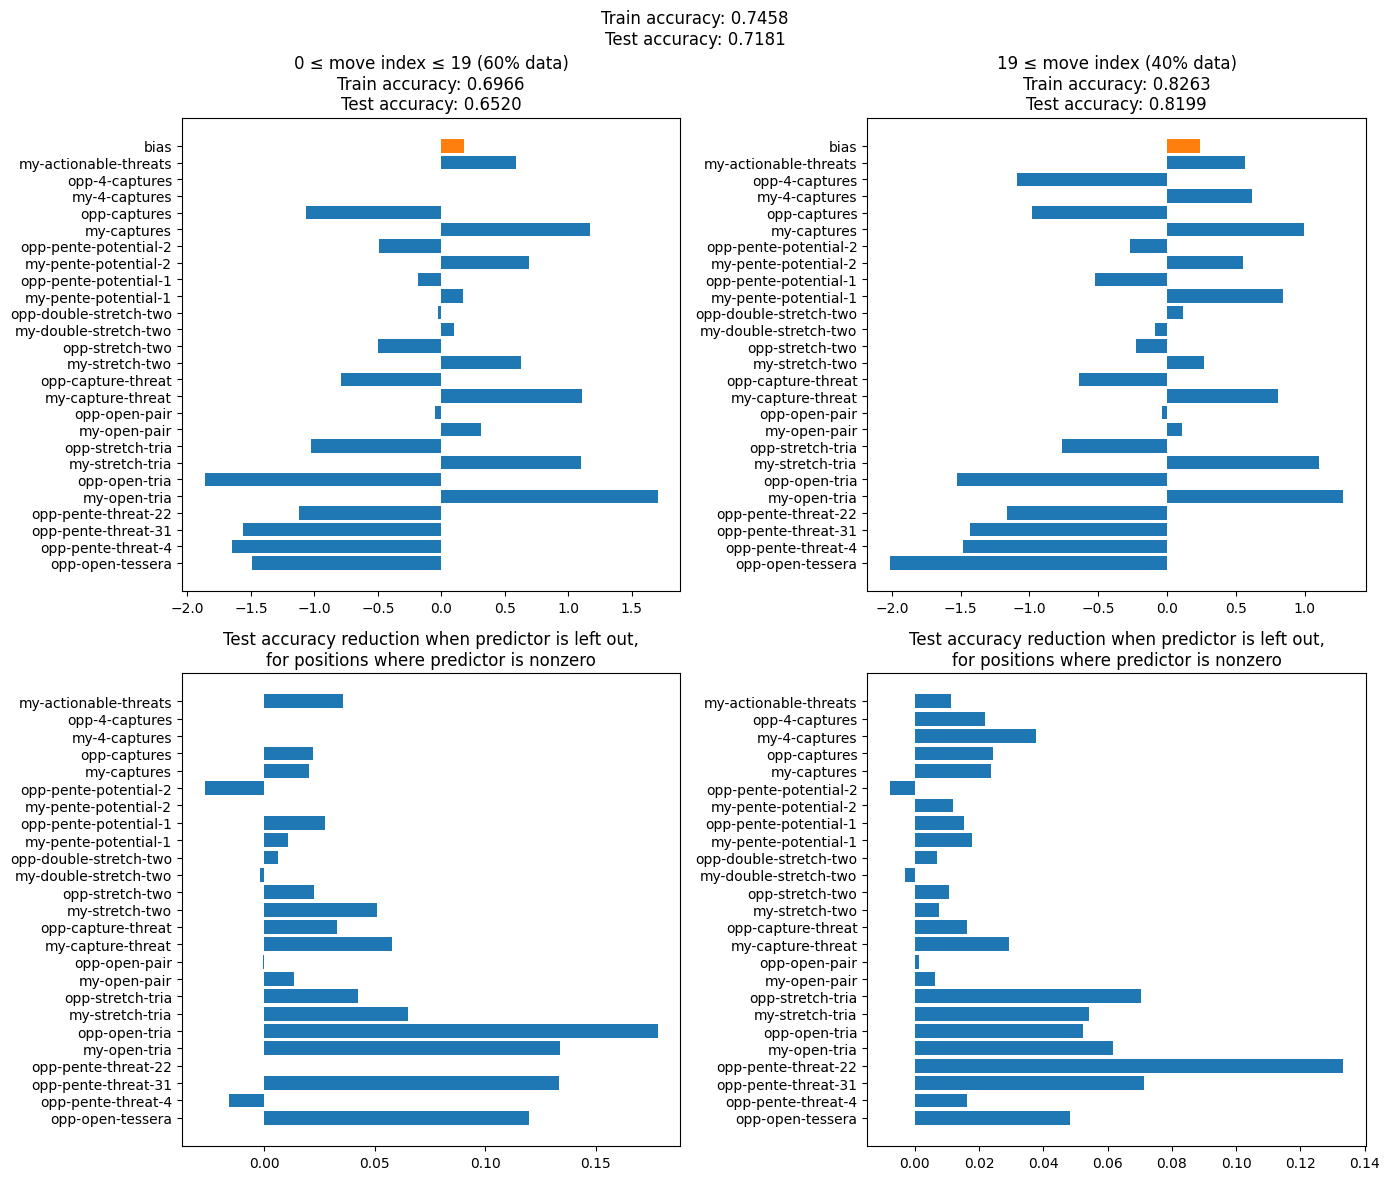

In [55]:
evaluate_features("features.csv", loco=True)

training 0.7437466831770742
testing 0.7165699731144757
Calculating variable importances


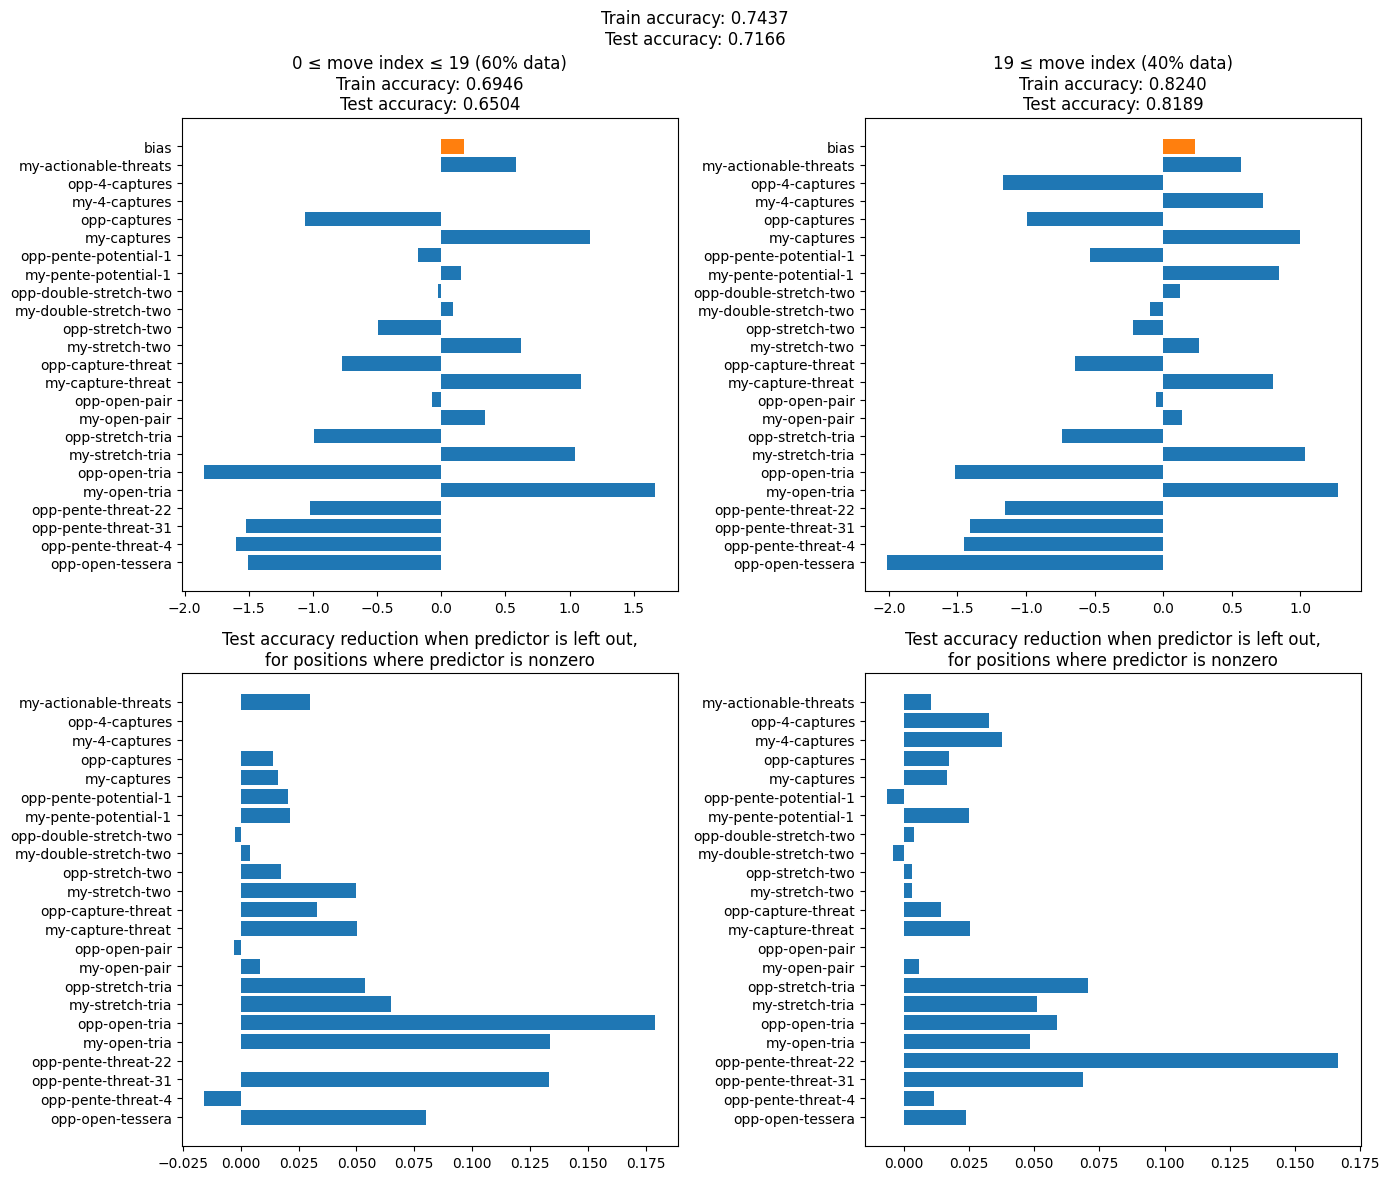

In [54]:
evaluate_features("features-alt.csv", loco=True)

In [4]:
# split vs. no split

data = pd.read_csv("features.csv")
X = data.drop(["won"], axis=1)
y = data["won"]

X_train, X_test, y_train, y_test = split_data(X, y, 0.8)

print("split")
model = EvaluationModel([0, 19], blend_range=2)
model.fit(X_train, y_train)
print("training", model.score(X_train, y_train))
print("testing", model.score(X_test, y_test))
# model.plot_coefs(X_test, y_test, loco=True)

print("no split")
model = EvaluationModel([0])
model.fit(X_train, y_train)
print("training", model.score(X_train, y_train))
print("testing", model.score(X_test, y_test))
# model.plot_coefs(X_test, y_test, loco=True)

split
training 0.7457633115160092
testing 0.7181265034668176
no split
training 0.7433575092871042
testing 0.7123248903353615
